In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa
from src.load_data import load_data
import pickle

import logging
logging.basicConfig(level=logging.INFO)

In [18]:
# parameters 

t1 = 32500 # start time from decode
t2 = 34500 # end time from decode
loaddata = 0 # loads pos, marks, theta, only have to load once if working across single epoch
savedata = 1 # saves results as .nc file, data as .pkl 

In [19]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [20]:
if loaddata==1:
    data = load_data(epoch_key)

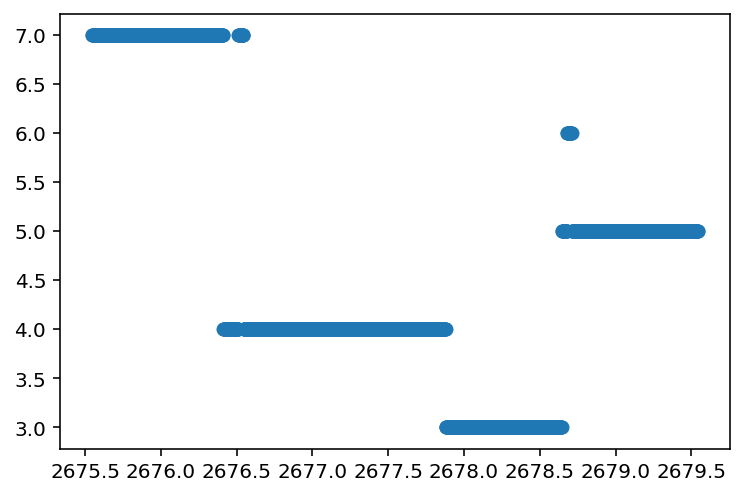

In [21]:
# plots segments over traversal

plt.scatter(data['position_info'][t1:t2].index / np.timedelta64(1, 's'), data['position_info'][t1:t2].track_segment_id) 

In [22]:
from dask.distributed import Client

client = Client(n_workers=16,
                threads_per_worker=2,
                processes=True,
                memory_limit='25GB')

In [23]:
from replay_trajectory_classification import ClusterlessDecoder

ClusterlessDecoder?

Init signature:
ClusterlessDecoder(
    place_bin_size=2.0,
    replay_speed=40,
    movement_var=0.05,
    position_range=None,
    model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
    model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
    occupancy_model=None,
    occupancy_kwargs=None,
    transition_type='random_walk',
    initial_conditions_type='uniform_on_track',
    infer_track_interior=True,
)
Docstring:     
Attributes
----------
place_bin_size : float, optional
    Approximate size of the position bins.
replay_speed : int, optional
    How many times faster the replay movement is than normal movement.
movement_var : float, optional
    How far the animal is can move in one time bin during normal
    movement.
position_range : sequence, optional
    A sequence of `n_position_dims`, each an optional (lower, upper)
    tuple giving the outer bin edges for position.
    An entry of None in the sequence results in the minimum and maximum
    values 

In [24]:
decoder = ClusterlessDecoder(transition_type='empirical_movement', replay_speed=40, place_bin_size=5)

In [25]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=5, position_range=None, replay_speed=40,
                   transition_type='uniform')

In [26]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def toc():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [27]:
tic()
results = decoder.predict(data['multiunits'].isel(time=slice(t1,t2)))
toc()

Time passed: 0hour:8min:9sec


In [34]:
if savedata==1:
    fpath = '/home/cwilhite/Src/cameron_alison_theta_decoding/Processed-Data/'
    results.to_netcdf(fpath + 'results_'+ str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + '_' + str(t1) + '_' + str(t2) + '.nc', 'w') # will override
    f = open(fpath + 'data_' + str(epoch_key[0]) + '_' + str(epoch_key[1]) + '_' + str(epoch_key[2]) + ".pkl","wb")
    pickle.dump(data,f)
    f.close()